# Poseidon Setup Between Chameleon And Fabric

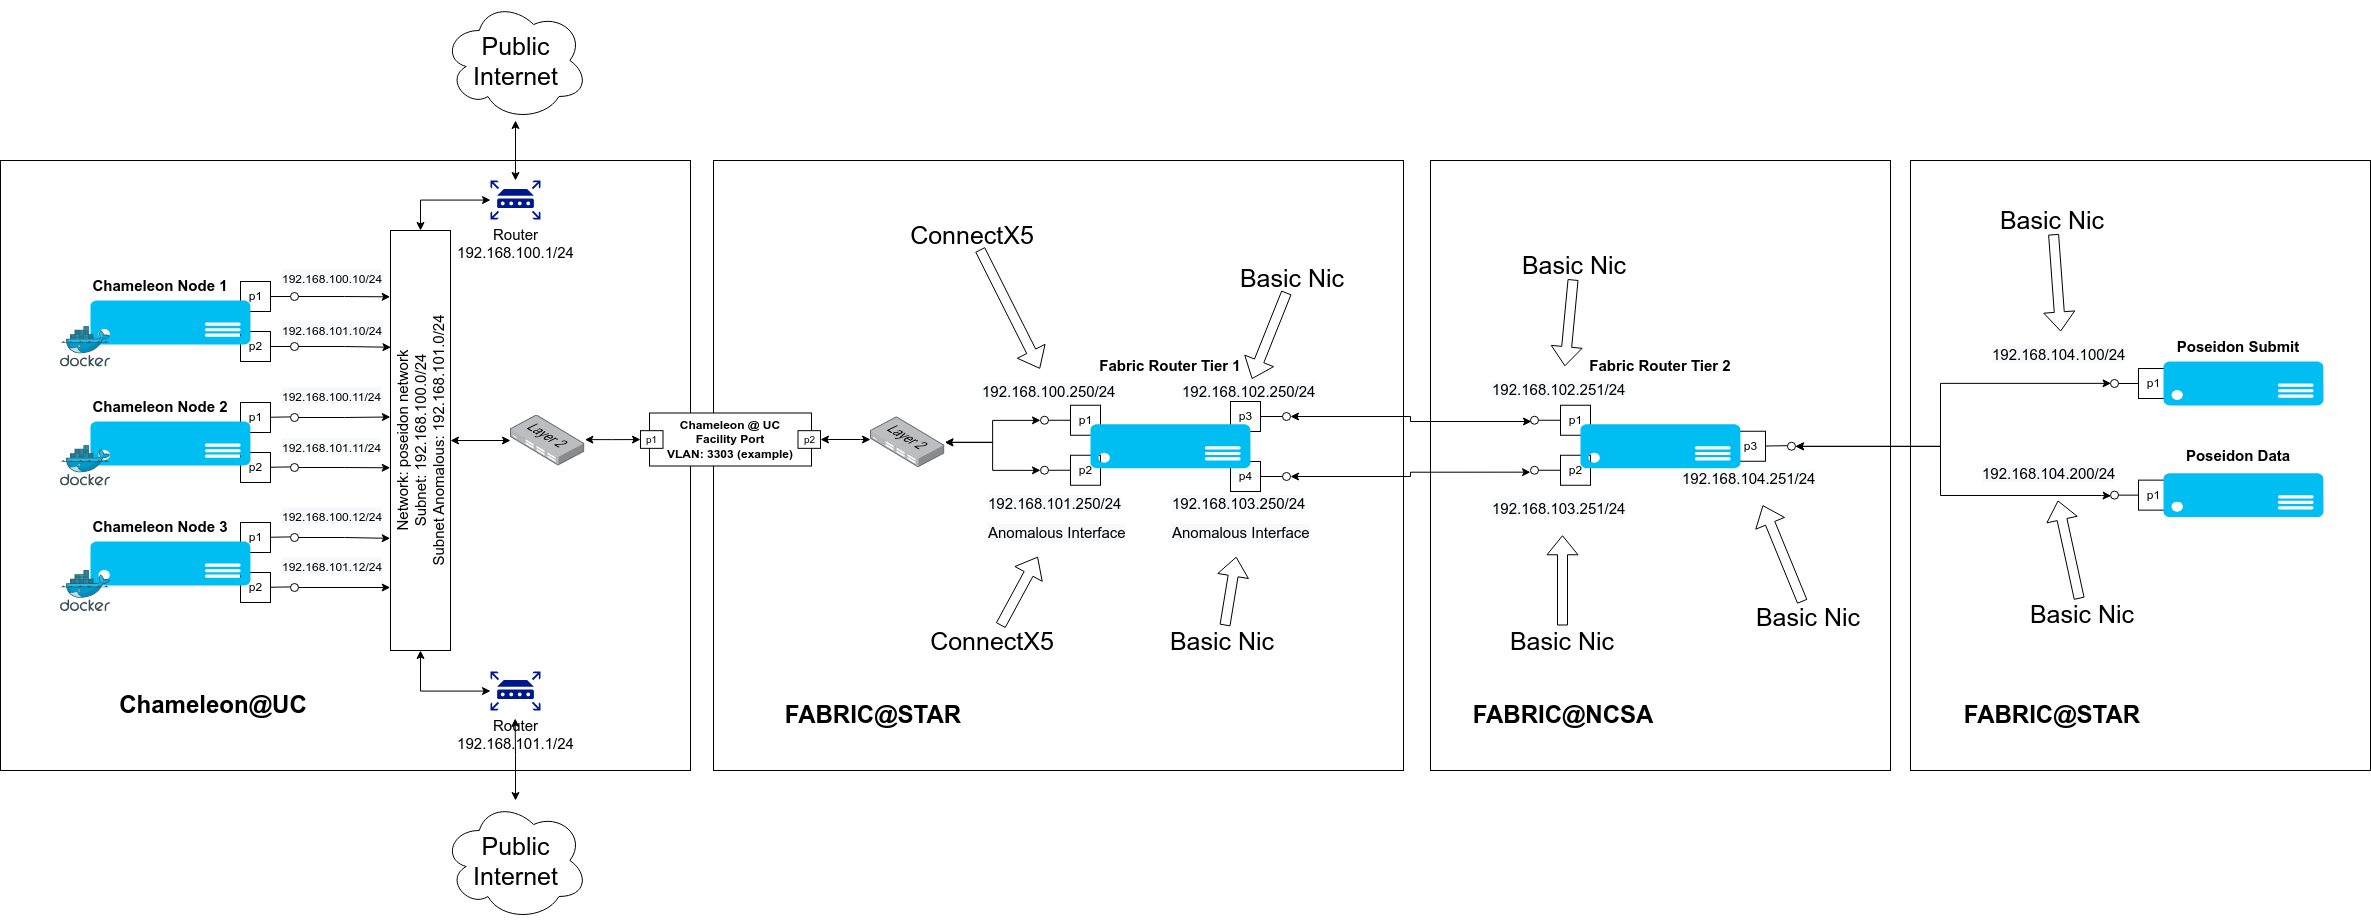

In [ ]:
import sys
import os
import json
import traceback
import time
from datetime import datetime, timedelta
from dateutil import tz
from ipaddress import ip_network, ip_address, IPv4Address, IPv6Address, IPv4Network, IPv6Network

## Chameleon Imports

In [ ]:
import chi
import chi.lease
from chi.clients import nova

## Fabric Imports

In [ ]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager

fablib = fablib_manager()

In [ ]:
try:
    fablib.list_sites(
        force_refresh=True, 
        fields=[
            "name", 
            "cores_available", 
            "ram_available",
            "disk_available",
            "nic_basic_available", 
            "nic_connectx_5_available", 
            "nic_connectx_6_available",
            "nvme_available",
            "tesla_t4_available",
            "rtx6000_available",
            "a30_available",
            "a40_available",
            "fpga_u280_available"
        ]
    )
except Exception as e:
    print(f"Exception: {e}")

In [ ]:
try:
    fablib.list_links()
except Exception as e:
    print(f"Exception: {e}")

In [ ]:
try:
    fablib.list_facility_ports()
except Exception as e:
    print(f"Exception: {e}")

## Chameleon Variables

For stitching to work we need to specify stich provider "fabric" and physical network "physnet1"

In [ ]:
# Chameleon Config
chameleon_prefix =  f"poseidon-"
chameleon_lease_name = chameleon_prefix+'lease'
chameleon_server_name = chameleon_prefix+'worker'
chameleon_network_name = chameleon_prefix+'net'
chameleon_subnet_name = chameleon_prefix+'subnet'
chameleon_router_name = chameleon_prefix+'router'
chameleon_network_name_anomalous = chameleon_prefix+'net_anomalous'
chameleon_subnet_name_anomalous = chameleon_prefix+'subnet_anomalous'
chameleon_router_name_anomalous = chameleon_prefix+'router_anomalous'

#chameleon_image_name='CC-Ubuntu20.04'
chameleon_image_name='poseidon-worker-ubuntu20.04'
chameleon_node_type="compute_cascadelake_r"
chameleon_physical_network='physnet1'
chameleon_stitch_provider='fabric'
chameleon_server_count=2 #max 10
chameleon_server_ips = ['192.168.100.10', '192.168.100.11', '192.168.100.12', '192.168.100.13', '192.168.100.14', '192.168.100.15', '192.168.100.16', '192.168.100.17', '192.168.100.18', '192.168.100.19']
chameleon_server_ips_anomalous = ['192.168.101.10', '192.168.101.11', '192.168.101.12', '192.168.101.13', '192.168.101.14', '192.168.101.15', '192.168.101.16', '192.168.101.17', '192.168.101.18', '192.168.101.19']
chameleon_key_name='fabric-chameleon'

#Chameleon Network Config
chameleon_subnet_addr = "192.168.100.0/24"
#chameleon_allocation_pool_start='192.168.100.10'
#chameleon_allocation_pool_end='192.168.100.20'
chameleon_gateway_ip_addr='192.168.100.1'

#Chameleon Network Config Anomalous
chameleon_subnet_addr_anomalous = "192.168.101.0/24"
#chameleon_allocation_pool_start_anomalous='192.168.101.10'
#chameleon_allocation_pool_end_anomalous='192.168.101.20'
chameleon_gateway_ip_addr_anomalous='192.168.101.1'

## Fabric Variables

In [ ]:
# Create a FABlib manager
fablib.show_config()

# FABRIC Config
fabric_prefix =  f"poseidon-"
fabric_slice_name = fabric_prefix+'experiment'
fabric_os_image='default_ubuntu_20'

fabric_facility_port_name = "Chameleon-StarLight"
fabric_facility_port_site = "STAR"

fabric_submit_name = fabric_prefix+'submit'
fabric_submit_site = 'STAR'
fabric_submit_host = 'star-w3.fabric-testbed.net'
fabric_submit_cores = 16
fabric_submit_ram = 32
fabric_submit_disk = 100
fabric_submit_ip_addr ="192.168.104.100"

fabric_data_name = fabric_prefix+'data'
fabric_data_site='STAR'
fabric_data_host='star-w2.fabric-testbed.net'
fabric_data_cores = 16
fabric_data_ram = 32
fabric_data_disk = 500
fabric_data_ip_addr ="192.168.104.200"

fabric_router_name = fabric_prefix+'router'
fabric_router_site = 'STAR'
fabric_router_host_tier_2 = 'star-w2.fabric-testbed.net'
fabric_router_cores = 16
fabric_router_ram = 32
fabric_router_disk = 100
fabric_router_ip_addr ="192.168.102.250"
fabric_router_ip_addr_anomalous ="192.168.103.250"
fabric_router_stitch_ip_addr ="192.168.100.250"
fabric_router_stitch_ip_addr_anomalous ="192.168.101.250"

fabric_router_name_tier_2 = fabric_prefix+'router_tier_2'
fabric_router_site_tier_2 = 'MICH'
fabric_router_host_tier_2 = 'mich-w2.fabric-testbed.net'
fabric_router_cores_tier_2 = 16
fabric_router_ram_tier_2 = 32
fabric_router_disk_tier_2 = 100
fabric_router_ip_addr_tier_2 ="192.168.102.251"
fabric_router_ip_addr_tier_2_anomalous ="192.168.103.251"
fabric_router_ip_addr_tier_3 ="192.168.104.251"

#Fabric Network Config
fabric_subnet_addr = "192.168.104.0/24"
fabric_chameleon_network_name = "fabric_chameleon_net"
fabric_chameleon_network_name_anomalous = "fabric_chameleon_net_anomalous"
fabric_network_name_tier_2 = "fabric_net_tier_2"
fabric_network_name_tier_2_anomalous = "fabric_net_name_tier_2_anomalous"
fabric_network_name_tier_3 = "fabric_net_tier_3"
#fabric_vlan_value = 1000

## Create Chameleon Lease For Compute and Network

In [ ]:
BLAZAR_TIME_FORMAT = '%Y-%m-%d %H:%M'

try:
    # Set start/end date for lease
    # Start one minute into future to avoid Blazar thinking lease is in past
    # due to rounding to closest minute.
    start_date = (datetime.now(tz=tz.tzutc()) + timedelta(minutes=1)).strftime(BLAZAR_TIME_FORMAT)
    end_date   = (datetime.now(tz=tz.tzutc()) + timedelta(days=1)).strftime(BLAZAR_TIME_FORMAT)

    # Build list of reservations (in this case there is only one reservation)
    reservation_list = []
    chi.lease.add_node_reservation(reservation_list, count=chameleon_server_count, node_type=chameleon_node_type)

    #reservation_list.append(
    #        {
    #            "resource_type": "network",
    #            "network_name": chameleon_network_name,
    #            "network_properties": "",
    #            "resource_properties": json.dumps(
    #                ["==", "$stitch_provider", chameleon_stitch_provider]
    #            ),
    #        }
    #)
    
    reservation_list.append(
            {
                "resource_type": "network",
                "network_name": chameleon_network_name,
                "network_properties": "",
                "resource_properties": json.dumps(
                    ["==", "$segment_id", "3308"]
                ),
            }
    )

    # Create the lease
    chameleon_lease = chi.lease.create_lease(chameleon_lease_name,
                                      reservations=reservation_list,
                                      start_date=start_date,
                                      end_date=end_date)

    #Print the lease info
    chameleon_compute_reservation_id = [reservation for reservation in chameleon_lease['reservations'] if reservation['resource_type'] == 'physical:host'][0]['id']
    print(f"chameleon_compute_reservation_id: {chameleon_compute_reservation_id}")
    chameleon_network_reservation_id = [reservation for reservation in chameleon_lease['reservations'] if reservation['resource_type'] == 'network'][0]['id']
    print(f"chameleon_network_reservation_id: {chameleon_network_reservation_id}")
except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

## Wait Until Networks Gets Provisioned

In [ ]:
chameleon_network = None
chameleon_network_id = None
chameleon_network_vlan = None

while chameleon_network_vlan == None:
    try:
        #Get the network
        chameleon_network = chi.network.get_network(chameleon_network_name)

        #Get the network ID
        chameleon_network_id = chameleon_network['id']
        print(f'Chameleon Network ID: {chameleon_network_id}')

        #Get the VLAN tag (needed for FABRIC stitching)
        chameleon_network_vlan = chameleon_network['provider:segmentation_id']
        print(f'Network VLAN: {chameleon_network_vlan}')
    except:
        print(f'Chameleon Network is not ready. Trying again!')
        time.sleep(10)           

## Create Chameleon's Subnet

In [ ]:
try:
    chameleon_subnet = chi.network.create_subnet(chameleon_subnet_name, chameleon_network_id, 
                                             cidr=str(chameleon_subnet_addr),
                                             gateway_ip=chameleon_gateway_ip_addr)
    chameleon_subnet_id = chameleon_subnet["id"]
except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

print(json.dumps(chameleon_subnet, indent=2))

In [ ]:
try:
    chameleon_subnet_anomalous = chi.network.create_subnet(chameleon_subnet_name_anomalous, chameleon_network_id, 
                                             cidr=str(chameleon_subnet_addr_anomalous),
                                             gateway_ip=chameleon_gateway_ip_addr_anomalous)
    chameleon_subnet_id_anomalous = chameleon_subnet_anomalous["id"]
except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

print(json.dumps(chameleon_subnet_anomalous, indent=2))

## Create Chameleon's Router and Add The Subnet

In [ ]:
try:
    chameleon_router = chi.network.create_router(chameleon_router_name, gw_network_name='public')
    chameleon_router = chi.network.add_subnet_to_router(chameleon_router['id'], chameleon_subnet_id)
    chameleon_router = chi.network.add_route_to_router(chameleon_router['id'], fabric_subnet_addr, fabric_router_stitch_ip_addr)
    print(json.dumps(chameleon_router, indent=2))
except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

In [ ]:
try:
    chameleon_router_anomalous = chi.network.create_router(chameleon_router_name_anomalous, gw_network_name='public')
    chameleon_router_anomalous = chi.network.add_subnet_to_router(chameleon_router_anomalous['id'], chameleon_subnet_id_anomalous)
    chameleon_router_anomalous = chi.network.add_route_to_router(chameleon_router_anomalous['id'], fabric_subnet_addr, fabric_router_stitch_ip_addr_anomalous)
    print(json.dumps(chameleon_router, indent=2))
except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

## Create Fabric Slice With Facility Port

Facility ports currently only work with the dedicate Smart Nics (ConnectX_5 and ConnectX_6)
Additionally stitching can work from within the same site that has the Facility Port or from VMs in different sites, but the connection type is L2PTP.
Finally each Facility Port has its own permission on Fabric which the project needs to gain access before using

In [ ]:
try:
    #Create Slice
    fabric_slice = fablib.new_slice(name=fabric_slice_name)
    
    # Add facility port
    fabric_facility_port = fabric_slice.add_facility_port(name=fabric_facility_port_name, site=fabric_facility_port_site, vlan=str(chameleon_network_vlan))
    fabric_facility_port_iface = fabric_facility_port.get_interfaces()[0]
    
    # Add poseidon router node
    fabric_router = fabric_slice.add_node(
                        name=fabric_router_name, 
                        site=fabric_router_site,
                        image=fabric_os_image,
                        cores=fabric_router_cores,
                        ram=fabric_router_ram,
                        disk=fabric_router_disk)
    
    fabric_router_nic = fabric_router.add_component(model='NIC_ConnectX_5', name="fabric_router_nic")
    fabric_router_iface_to_chameleon = fabric_router_nic.get_interfaces()[0]
    fabric_router_iface_to_chameleon_anomalous = fabric_router_nic.get_interfaces()[1]
    #fabric_router_iface_to_chameleon.set_vlan(fabric_vlan_value)

    fabric_router_nic_tier_2 = fabric_router.add_component(model='NIC_Basic', name="fabric_router_nic_tier_2")
    fabric_router_iface_tier_2 = fabric_router_nic_tier_2.get_interfaces()[0]
    #fabric_router_iface_tier_2.set_vlan(fabric_vlan_value)
    
    fabric_router_nic_tier_2_anomalous = fabric_router.add_component(model='NIC_Basic', name="fabric_router_nic_tier_2_anomalous")
    fabric_router_iface_tier_2_anomalous = fabric_router_nic_tier_2_anomalous.get_interfaces()[0]
    #fabric_router_iface_tier_2_anomalous.set_vlan(fabric_vlan_value)

    # Add poseidon router node
    fabric_router_tier_2 = fabric_slice.add_node(
                        name=fabric_router_name_tier_2, 
                        site=fabric_router_site_tier_2,
                        host=fabric_router_host_tier_2,
                        image=fabric_os_image,
                        cores=fabric_router_cores_tier_2,
                        ram=fabric_router_ram_tier_2,
                        disk=fabric_router_disk_tier_2)

    fabric_router_tier_2_iface_tier_2 = fabric_router_tier_2.add_component(model='NIC_Basic', name="fabric_router_tier_2_nic_tier_2").get_interfaces()[0]
    #fabric_router_tier_2_iface_tier_2.set_vlan(fabric_vlan_value)
    
    fabric_router_tier_2_iface_tier_2_anomalous = fabric_router_tier_2.add_component(model='NIC_Basic', name="fabric_router_tier_2_nic_tier_2_anomalous").get_interfaces()[0]
    #fabric_router_tier_2_iface_tier_2_anomalous.set_vlan(fabric_vlan_value)

    fabric_router_tier_2_iface_to_fabric = fabric_router_tier_2.add_component(model='NIC_Basic', name="fabric_router_tier_2_nic_to_fabric").get_interfaces()[0]
    #fabric_router_tier_2_iface_to_fabric.set_vlan(fabric_vlan_value)
    
    # Add poseidon submit node
    fabric_submit = fabric_slice.add_node(
                        name=fabric_submit_name, 
                        site=fabric_submit_site,
                        host=fabric_submit_host,
                        image=fabric_os_image,
                        cores=fabric_submit_cores,
                        ram=fabric_submit_ram,
                        disk=fabric_submit_disk)
    
    fabric_submit_iface = fabric_submit.add_component(model='NIC_Basic', name="fabric_submit_nic").get_interfaces()[0]
    #fabric_submit_iface.set_vlan(fabric_vlan_value)
    
    # Add poseidon router node
    fabric_data = fabric_slice.add_node(
                    name=fabric_data_name, 
                    site=fabric_data_site,
                    host=fabric_data_host,
                    image=fabric_os_image,
                    cores=fabric_data_cores,
                    ram=fabric_data_ram,
                    disk=fabric_data_disk)
    
    fabric_data_iface = fabric_data.add_component(model='NIC_Basic', name="fabric_data_nic").get_interfaces()[0]
    #fabric_data_iface.set_vlan(fabric_vlan_value)
    
    #Create the l2networks
    fabric_chameleon_net = fabric_slice.add_l2network(name=fabric_chameleon_network_name, interfaces=[fabric_router_iface_to_chameleon,
                                                                                                      fabric_router_iface_to_chameleon_anomalous,
                                                                                                      fabric_facility_port_iface])
    
    fabric_net_tier_2 = fabric_slice.add_l2network(name=fabric_network_name_tier_2, interfaces=[fabric_router_iface_tier_2,
                                                                                         fabric_router_tier_2_iface_tier_2])

    fabric_net_tier_2_anomalous = fabric_slice.add_l2network(name=fabric_network_name_tier_2_anomalous, interfaces=[fabric_router_iface_tier_2_anomalous,
                                                                                         fabric_router_tier_2_iface_tier_2_anomalous])
    
    fabric_net_tier_3 = fabric_slice.add_l2network(name=fabric_network_name_tier_3, interfaces=[fabric_router_tier_2_iface_to_fabric,
                                                                                         fabric_submit_iface,
                                                                                         fabric_data_iface])

    #Submit the Request
    fabric_slice.submit()
except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

## Configure Network on Fabric Router With Facility Port Attached (Tier 1)

In [ ]:
try:
    fabric_slice = fablib.get_slice(name=fabric_slice_name)
    fabric_router = fabric_slice.get_node(name=fabric_router_name)

    node_iface_name = f"{fabric_router_name}-fabric_router_nic-p1"
    fabric_router_iface_to_chameleon = fabric_router.get_interface(name=node_iface_name)
    node_iface_name = f"{fabric_router_name}-fabric_router_nic-p2"
    fabric_router_iface_to_chameleon_anomalous = fabric_router.get_interface(name=node_iface_name)
    node_iface_name = f"{fabric_router_name}-fabric_router_nic_tier_2-p1"
    fabric_router_iface_to_tier_2 = fabric_router.get_interface(name=node_iface_name)
    node_iface_name = f"{fabric_router_name}-fabric_router_nic_tier_2_anomalous-p1"
    fabric_router_iface_to_tier_2_anomalous = fabric_router.get_interface(name=node_iface_name)

    fabric_router_iface_to_chameleon_os_name = fabric_router_iface_to_chameleon.get_os_interface()
    fabric_router_iface_to_chameleon_anomalous_os_name = fabric_router_iface_to_chameleon_anomalous.get_os_interface()
    fabric_router_iface_to_tier_2_os_name = fabric_router_iface_to_tier_2.get_os_interface()
    fabric_router_iface_to_tier_2_anomalous_os_name = fabric_router_iface_to_tier_2_anomalous.get_os_interface()

    stdout, stderr = fabric_router.execute(f'sudo ip link set dev {fabric_router_iface_to_chameleon_os_name} up', quiet=True)
    #stdout, stderr = fabric_router.execute(f'sudo ip link set mtu 8900 dev {fabric_router_iface_to_chameleon_os_name}', quiet=True)
    stdout, stderr = fabric_router.execute(f'sudo ip addr add {fabric_router_stitch_ip_addr}/24 dev {fabric_router_iface_to_chameleon_os_name}', quiet=True)
    stdout, stderr = fabric_router.execute(f'sudo tc qdisc add dev {fabric_router_iface_to_chameleon_os_name} root fq', quiet=True)

    stdout, stderr = fabric_router.execute(f'sudo ip link set dev {fabric_router_iface_to_chameleon_anomalous_os_name} up', quiet=True)
    #stdout, stderr = fabric_router.execute(f'sudo ip link set mtu 8900 dev {fabric_router_iface_to_fabric_os_name}', quiet=True)
    stdout, stderr = fabric_router.execute(f'sudo ip addr add {fabric_router_stitch_ip_addr_anomalous}/24 dev {fabric_router_iface_to_chameleon_anomalous_os_name}', quiet=True)
    stdout, stderr = fabric_router.execute(f'sudo tc qdisc add dev {fabric_router_iface_to_chameleon_anomalous_os_name} root fq', quiet=True)

    stdout, stderr = fabric_router.execute(f'sudo ip link set dev {fabric_router_iface_to_tier_2_os_name} up', quiet=True)
    #stdout, stderr = fabric_router.execute(f'sudo ip link set mtu 8900 dev {fabric_router_iface_to_fabric_os_name}', quiet=True)
    stdout, stderr = fabric_router.execute(f'sudo ip addr add {fabric_router_ip_addr}/24 dev {fabric_router_iface_to_tier_2_os_name}', quiet=True)
    stdout, stderr = fabric_router.execute(f'sudo tc qdisc add dev {fabric_router_iface_to_tier_2_os_name} root fq', quiet=True)

    stdout, stderr = fabric_router.execute(f'sudo ip link set dev {fabric_router_iface_to_tier_2_anomalous_os_name} up', quiet=True)
    #stdout, stderr = fabric_router.execute(f'sudo ip link set mtu 8900 dev {fabric_router_iface_to_fabric_os_name}', quiet=True)
    stdout, stderr = fabric_router.execute(f'sudo ip addr add {fabric_router_ip_addr_anomalous}/24 dev {fabric_router_iface_to_tier_2_anomalous_os_name}', quiet=True)
    stdout, stderr = fabric_router.execute(f'sudo tc qdisc add dev {fabric_router_iface_to_tier_2_anomalous_os_name} root fq', quiet=True)


    #### THESE RULES ARE MAGIC - PAY ATTENTION ####
    #add default gateway
    stdout, stderr = fabric_router.execute(f'sudo ip route add default via {chameleon_gateway_ip_addr}', quiet=True)
    #add default route to the fabric node subnet
    stdout, stderr = fabric_router.execute(f'sudo ip route add 192.168.104.0/24 via {fabric_router_ip_addr_tier_2}', quiet=True)
    #add alternative anomalous route to the fabric node subnet
    stdout, stderr = fabric_router.execute(f'sudo ip route add 192.168.104.0/24 via {fabric_router_ip_addr_tier_2_anomalous} table 1000', quiet=True)
    #only use alrternative anomalous route if packets are coming into anomalous facility port interface
    stdout, stderr = fabric_router.execute(f'sudo ip rule add iif {fabric_router_iface_to_chameleon_anomalous_os_name} lookup 1000', quiet=True)
    
    #enable ip forwarding
    stdout, stderr = fabric_router.execute('sudo sysctl -w net.ipv4.ip_forward=1', quiet=True)

    #add post routing rule to iptables that adds as source the anomalous interfaces to fabric before it gets sent
    stdout, stderr = fabric_router.execute(f'sudo iptables -t nat -A POSTROUTING -o {fabric_router_iface_to_tier_2_anomalous_os_name} -j SNAT --to-source {fabric_router_ip_addr_anomalous}')
    #stdout, stderr = fabric_router.execute('sudo /sbin/iptables-save > /etc/iptables/rules.v4')
    
    stdout, stderr = fabric_router.execute(f'ip route show', quiet=True)
    print (stdout)
    
    stdout, stderr = fabric_router.execute(f'ip addr show', quiet=True)
    print (stdout)
except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

## Configure Network on Fabric Router Tier 2

In [ ]:
try:
    fabric_slice = fablib.get_slice(name=fabric_slice_name)
    fabric_router_tier_2 = fabric_slice.get_node(name=fabric_router_name_tier_2)

    node_iface_name = f"{fabric_router_name_tier_2}-fabric_router_tier_2_nic_tier_2-p1"
    fabric_router_tier_2_iface_to_tier_1 = fabric_router_tier_2.get_interface(name=node_iface_name)
    node_iface_name = f"{fabric_router_name_tier_2}-fabric_router_tier_2_nic_tier_2_anomalous-p1"
    fabric_router_tier_2_iface_to_tier_1_anomalous = fabric_router_tier_2.get_interface(name=node_iface_name)
    node_iface_name = f"{fabric_router_name_tier_2}-fabric_router_tier_2_nic_to_fabric-p1"
    fabric_router_tier_2_iface_to_tier_3 = fabric_router_tier_2.get_interface(name=node_iface_name)

    fabric_router_tier_2_iface_to_tier_1_os_name = fabric_router_tier_2_iface_to_tier_1.get_os_interface()
    fabric_router_tier_2_iface_to_tier_1_anomalous_os_name = fabric_router_tier_2_iface_to_tier_1_anomalous.get_os_interface()
    fabric_router_tier_2_iface_to_tier_3_os_name = fabric_router_tier_2_iface_to_tier_3.get_os_interface()

    stdout, stderr = fabric_router_tier_2.execute(f'sudo ip link set dev {fabric_router_tier_2_iface_to_tier_1_os_name} up', quiet=True)
    #stdout, stderr = fabric_router_tier_2.execute(f'sudo ip link set mtu 8900 dev {fabric_router_iface_to_chameleon_os_name}', quiet=True)
    stdout, stderr = fabric_router_tier_2.execute(f'sudo ip addr add {fabric_router_ip_addr_tier_2}/24 dev {fabric_router_tier_2_iface_to_tier_1_os_name}', quiet=True)
    stdout, stderr = fabric_router_tier_2.execute(f'sudo tc qdisc add dev {fabric_router_tier_2_iface_to_tier_1_os_name} root fq', quiet=True)

    stdout, stderr = fabric_router_tier_2.execute(f'sudo ip link set dev {fabric_router_tier_2_iface_to_tier_1_anomalous_os_name} up', quiet=True)
    #stdout, stderr = fabric_router_tier_2.execute(f'sudo ip link set mtu 8900 dev {fabric_router_iface_to_fabric_os_name}', quiet=True)
    stdout, stderr = fabric_router_tier_2.execute(f'sudo ip addr add {fabric_router_ip_addr_tier_2_anomalous}/24 dev {fabric_router_tier_2_iface_to_tier_1_anomalous_os_name}', quiet=True)
    stdout, stderr = fabric_router_tier_2.execute(f'sudo tc qdisc add dev {fabric_router_tier_2_iface_to_tier_1_anomalous_os_name} root fq', quiet=True)

    stdout, stderr = fabric_router_tier_2.execute(f'sudo ip link set dev {fabric_router_tier_2_iface_to_tier_3_os_name} up', quiet=True)
    #stdout, stderr = fabric_router_tier_2.execute(f'sudo ip link set mtu 8900 dev {fabric_router_iface_to_fabric_os_name}', quiet=True)
    stdout, stderr = fabric_router_tier_2.execute(f'sudo ip addr add {fabric_router_ip_addr_tier_3}/24 dev {fabric_router_tier_2_iface_to_tier_3_os_name}', quiet=True)
    stdout, stderr = fabric_router_tier_2.execute(f'sudo tc qdisc add dev {fabric_router_tier_2_iface_to_tier_3_os_name} root fq', quiet=True)

    #add default gateway
    stdout, stderr = fabric_router_tier_2.execute(f'sudo ip route add default via {fabric_router_ip_addr}', quiet=True)
    #add route to the chameleon nodes subnet
    stdout, stderr = fabric_router_tier_2.execute(f'sudo ip route add 192.168.100.0/24 via {fabric_router_ip_addr}', quiet=True)
    #add route to the chameleon nodes subnet anomalous
    stdout, stderr = fabric_router_tier_2.execute(f'sudo ip route add 192.168.101.0/24 via {fabric_router_ip_addr_anomalous}', quiet=True)
    
    #enable ip forwarding
    stdout, stderr = fabric_router_tier_2.execute('sudo sysctl -w net.ipv4.ip_forward=1', quiet=True)
    
    stdout, stderr = fabric_router_tier_2.execute(f'ip route show', quiet=True)
    print (stdout)
    
    stdout, stderr = fabric_router_tier_2.execute(f'ip addr show', quiet=True)
    print (stdout)
except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

## Configure Network on Submit Node

In [ ]:
try:
    fabric_slice = fablib.get_slice(name=fabric_slice_name)
    fabric_submit = fabric_slice.get_node(name=fabric_submit_name)
    
    fabric_submit_iface = fabric_submit.get_interface(network_name=fabric_network_name_tier_3)
    fabric_submit_iface_os_name = fabric_submit_iface.get_os_interface()

    stdout, stderr = fabric_submit.execute(f'sudo ip link set dev {fabric_submit_iface_os_name} up', quiet=True)
    #stdout, stderr = fabric_submit.execute(f'sudo ip link set mtu 8900 dev {fabric_submit_iface_os_name}', quiet=True)
    stdout, stderr = fabric_submit.execute(f'sudo ip addr add {fabric_submit_ip_addr}/24 dev {fabric_submit_iface_os_name}', quiet=True)
    stdout, stderr = fabric_submit.execute(f'sudo tc qdisc add dev {fabric_submit_iface_os_name} root fq', quiet=True)
    
    #add default gateway and route to chameleon subnet via router
    #stdout, stderr = fabric_submit.execute(f'sudo ip route add {chameleon_subnet_address} via {fabric_router_ip_addr}', quiet=True)
    stdout, stderr = fabric_submit.execute(f'sudo ip route add default via {fabric_router_ip_addr_tier_3}', quiet=True)

    stdout, stderr = fabric_submit.execute(f'ip route show', quiet=True)
    print (stdout)
    
    stdout, stderr = fabric_submit.execute(f'ip addr show', quiet=True)
    print (stdout)
except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

## Configure Network on Data Node

In [ ]:
try:
    fabric_slice = fablib.get_slice(name=fabric_slice_name)
    fabric_data = fabric_slice.get_node(name=fabric_data_name)
    
    fabric_data_iface = fabric_data.get_interface(network_name=fabric_network_name_tier_3)
    fabric_data_iface_os_name = fabric_data_iface.get_os_interface()

    stdout, stderr = fabric_data.execute(f'sudo ip link set dev {fabric_data_iface_os_name} up', quiet=True)
    #stdout, stderr = fabric_data.execute(f'sudo ip link set mtu 8900 dev {fabric_data_iface_os_name}', quiet=True)
    stdout, stderr = fabric_data.execute(f'sudo ip addr add {fabric_data_ip_addr}/24 dev {fabric_data_iface_os_name}', quiet=True)
    stdout, stderr = fabric_data.execute(f'sudo tc qdisc add dev {fabric_data_iface_os_name} root fq', quiet=True)
    
    #add default gateway and route to chameleon subnet via router
    #stdout, stderr = fabric_data.execute(f'sudo ip route add {chameleon_subnet_address} via {fabric_router_ip_addr}', quiet=True)
    stdout, stderr = fabric_data.execute(f'sudo ip route add default via {fabric_router_ip_addr_tier_3}', quiet=True)

    stdout, stderr = fabric_data.execute(f'ip route show', quiet=True)
    print (stdout)
    
    stdout, stderr = fabric_data.execute(f'ip addr show', quiet=True)
    print (stdout)
except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

## Sanity Check: Ping Chameleon Router From Fabric

In [ ]:
try:
    fabric_slice = fablib.get_slice(name=fabric_slice_name)
    fabric_node = fabric_slice.get_node(name=fabric_router_name) 
    stdout, stderr = fabric_node.execute(f'ping -c 4 {chameleon_gateway_ip_addr}')
    stdout, stderr = fabric_node.execute(f'ping -c 4 {chameleon_gateway_ip_addr_anomalous}')
except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

## Sanity Check: Ping Fabric Router Tier 1 From Fabric Router Tier 2

In [ ]:
try:
    fabric_slice = fablib.get_slice(name=fabric_slice_name)
    fabric_node = fabric_slice.get_node(name=fabric_router_name_tier_2) 
    stdout, stderr = fabric_node.execute(f'ping -c 4 {fabric_router_ip_addr}')
    stdout, stderr = fabric_node.execute(f'ping -c 4 {fabric_router_ip_addr_anomalous}')
except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

# Sanity Check: Ping Fabric Nodes From Fabric Router Tier 1

In [ ]:
try:
    fabric_slice = fablib.get_slice(name=fabric_slice_name)
    fabric_node = fabric_slice.get_node(name=fabric_router_name) 
    stdout, stderr = fabric_node.execute(f'ping -c 4 {fabric_submit_ip_addr}')
    stdout, stderr = fabric_node.execute(f'ping -c 4 {fabric_data_ip_addr}')
except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

## Sanity Check: Ping Fabric Nodes From Fabric Router Tier 2

In [ ]:
try:
    fabric_slice = fablib.get_slice(name=fabric_slice_name)
    fabric_node = fabric_slice.get_node(name=fabric_router_name_tier_2) 
    stdout, stderr = fabric_node.execute(f'ping -c 4 {fabric_submit_ip_addr}')
    stdout, stderr = fabric_node.execute(f'ping -c 4 {fabric_data_ip_addr}')
except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

## Sanity Check: Ping Chameleon Router From Fabric Nodes

In [ ]:
try:
    fabric_slice = fablib.get_slice(name=fabric_slice_name)
    fabric_node = fabric_slice.get_node(name=fabric_submit_name) 
    stdout, stderr = fabric_node.execute(f'ping -c 4 {chameleon_gateway_ip_addr}')
    
    fabric_node = fabric_slice.get_node(name=fabric_data_name) 
    stdout, stderr = fabric_node.execute(f'ping -c 4 {chameleon_gateway_ip_addr}')
except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

## Install Software on Fabric

In [ ]:
from ipaddress import ip_address, IPv6Address

try:
    fabric_slice = fablib.get_slice(name=fabric_slice_name)
    
    fabric_node = fabric_slice.get_node(name=fabric_router_name)
    fabric_node.upload_file("fabric/fabric-router.sh", "/home/ubuntu/setup.sh")
    if type(ip_address(fabric_node.get_management_ip())) is IPv6Address:
        fabric_node.execute("sudo sed -i 's/nameserver/nameserver 2a01:4f9:c010:3f02::1\nnameserver 2a00:1098:2c::1\nnameserver 2a00:1098:2b::1\nnameserver/' /etc/resolv.conf", quiet=True)

    fabric_node = fabric_slice.get_node(name=fabric_router_name_tier_2)
    fabric_node.upload_file("fabric/fabric-router.sh", "/home/ubuntu/setup.sh")
    if type(ip_address(fabric_node.get_management_ip())) is IPv6Address:
        fabric_node.execute("sudo sed -i 's/nameserver/nameserver 2a01:4f9:c010:3f02::1\\nnameserver 2a00:1098:2c::1\\nnameserver 2a00:1098:2b::1\\nnameserver/' /etc/resolv.conf", quiet=True)
    
    fabric_node = fabric_slice.get_node(name=fabric_submit_name)
    fabric_node.upload_file("fabric/fabric-submit.sh", "/home/ubuntu/setup.sh")
    #fabric_node.execute(f"echo '{fabric_data_ip_addr} poseidon-data' | sudo tee -a /etc/hosts", quiet=True)
    if type(ip_address(fabric_node.get_management_ip())) is IPv6Address:
        fabric_node.execute("sudo sed -i 's/nameserver/nameserver 2a01:4f9:c010:3f02::1\\nnameserver 2a00:1098:2c::1\\nnameserver 2a00:1098:2b::1\\nnameserver/' /etc/resolv.conf", quiet=True)

    fabric_node = fabric_slice.get_node(name=fabric_data_name)
    fabric_node.upload_file("fabric/fabric-data.sh", "/home/ubuntu/setup.sh")
    #fabric_node.execute(f"echo '{fabric_submit_ip_addr} poseidon-submit' | sudo tee -a /etc/hosts", quiet=True)
    if type(ip_address(fabric_node.get_management_ip())) is IPv6Address:
        fabric_node.execute("sudo sed -i 's/nameserver/nameserver 2a01:4f9:c010:3f02::1\\nnameserver 2a00:1098:2c::1\\nnameserver 2a00:1098:2b::1\\nnameserver/' /etc/resolv.conf", quiet=True)

except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

In [ ]:
try:
    config_command = "sudo bash /home/ubuntu/setup.sh"
    
    fabric_slice = fablib.get_slice(name=fabric_slice_name)
    
    #Create execute threads
    execute_threads = {}
    for fabric_node in fabric_slice.get_nodes():
        if fabric_node.get_name() == fabric_submit_name:
            continue
        print(f"Starting config on node {fabric_node.get_name()}")
        execute_threads[fabric_node] = fabric_node.execute_thread(config_command)
        
    #Wait for results from threads
    for fabric_node,thread in execute_threads.items():
        print(f"Waiting for result from node {fabric_node.get_name()}")
        stdout,stderr = thread.result()

    #data node depends on submit node
    fabric_node = fabric_slice.get_node(name=fabric_submit_name)
    print(f"Starting config on node {fabric_submit_name}")
    print(f"Waiting for result from node {fabric_submit_name}")
    fabric_node.execute(config_command, quiet=True)
                        
    print("All Done!")
except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

## Create Chameleon Nodes If Router Responds to Ping

In [ ]:
servers=[]
from chi.clients import connection, glance, nova, neutron
try:
    for i in range(chameleon_server_count):
        server_name=f"{chameleon_server_name}-{i}"
        
        # Create the server
        #servers.append(chi.server.create_server(server_name, 
        #                reservation_id=chameleon_compute_reservation_id,
        #                nics=[{"net-id": chameleon_network_id, "v4-fixed-ip": chameleon_server_ips[i]}, {"net-id": chameleon_network_id, "v4-fixed-ip": chameleon_server_ips_anomalous[i]}],
        #                image_name=chameleon_image_name,
        #                key_name=chameleon_key_name,
        #                userdata="chameleon/chameleon-baremetal.sh"))
        #continue
        scheduler_hints = {}
        scheduler_hints['reservation'] = chameleon_compute_reservation_id

        servers.append(nova().servers.create(
            name=server_name,
            image=chi.server.get_image_id(chameleon_image_name),
            flavor=next((f.id for f in chi.server.list_flavors()), None),
            scheduler_hints=scheduler_hints,
            key_name=chameleon_key_name,
            nics=[{"net-id": chameleon_network_id, "v4-fixed-ip": chameleon_server_ips[i]}, {"net-id": chameleon_network_id, "v4-fixed-ip": chameleon_server_ips_anomalous[i]}],
            min_count=1,
            max_count=1,
            hypervisor_hostname=None,
            userdata=open("chameleon/chameleon-baremetal.sh", 'r').read()
        ))
        time.sleep(30)

except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

for server in servers:
    chi.server.wait_for_active(server.id)

In [ ]:
# Give 5 more minutes for the Chameleon Nodes to Stabilize
time.sleep(200)

## Get Chameleon Worker IPs

In [ ]:
chameleon_fixed_ips={}

try:
    for i in range(chameleon_server_count):
        chi_server_name=f"{chameleon_server_name}-{i}"
        chi_server_id = chi.server.get_server_id(chi_server_name)
        #chi_fixed_ip_0 = chi.server.get_server(chi_server_id).interface_list()[0].to_dict()["fixed_ips"][0]["ip_address"]
        #chi_fixed_ip_1 = chi.server.get_server(chi_server_id).interface_list()[1].to_dict()["fixed_ips"][0]["ip_address"]
        chi_fixed_ip = chameleon_server_ips[i]
        chi_fixed_ip_anomalous = chameleon_server_ips_anomalous[i]
        chameleon_fixed_ips[chi_server_name]=[chi_fixed_ip, chi_fixed_ip_anomalous]
except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()
    
for chi_server_name,chi_fixed_ip in chameleon_fixed_ips.items():
    print(f'{chi_server_name}: {chi_fixed_ip}')

## Sanity Check: Ping Chameleon Nodes From Fabric (If this step doesn't succeed the next step will fail)

In [ ]:
try:
    fabric_slice = fablib.get_slice(name=fabric_slice_name)
    fabric_node = fabric_slice.get_node(name=fabric_submit_name)
    
    for chi_server_name,chi_fixed_ip in chameleon_fixed_ips.items():
        stdout, stderr = fabric_node.execute(f'ping -c 4 {chi_fixed_ip[0]}')
        stdout, stderr = fabric_node.execute(f'ping -c 4 {chi_fixed_ip[1]}')
        
except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

## Create Docker Networks on Chameleon Nodes (use the fabric submit node to connect)

In [ ]:
#get a list of ip network ranges with 16 ip addresses each, and skip the first 2 ranges.
ip_range_list = list(ip_network(chameleon_subnet_addr).subnets(4))[2:]
ip_range_list_anomalous = list(ip_network(chameleon_subnet_addr_anomalous).subnets(4))[2:]
nic_name_cmd = f"ip route | grep {chameleon_subnet_addr} | cut -d' ' -f 3"
nic_name_cmd_anomalous = f"ip route | grep {chameleon_subnet_addr_anomalous} | cut -d' ' -f 3"
docker_network_cmd = f"docker network create -d ipvlan --subnet={chameleon_subnet_addr} --gateway={chameleon_gateway_ip_addr}" + " --ip-range={0} -o parent={1} -o ipvlan_mode=l2 poseidon_net"
docker_network_cmd_anomalous = f"docker network create -d ipvlan --subnet={chameleon_subnet_addr_anomalous} --gateway={chameleon_gateway_ip_addr_anomalous}" + " --ip-range={0} -o parent={1} -o ipvlan_mode=l2 poseidon_net_anomalous"

try:
    fabric_slice = fablib.get_slice(name=fabric_slice_name)
    fabric_node = fabric_slice.get_node(name=fabric_submit_name)

    subnet_index = 0
    for chi_server_name,chi_fixed_ip in chameleon_fixed_ips.items():
        stdout, stderr = fabric_node.execute(f'sudo su - poseidon -c "ssh -o StrictHostKeyChecking=no poseidon@{chi_fixed_ip[0]} \"\"{nic_name_cmd}\"\""', quiet=True)
        os_interface = stdout.replace("\n","")
        stdout, stderr = fabric_node.execute(f'sudo su - poseidon -c "ssh -o StrictHostKeyChecking=no poseidon@{chi_fixed_ip[0]} \"\"{nic_name_cmd_anomalous}\"\""', quiet=True)
        os_interface_anomalous = stdout.replace("\n","")
        
        print(docker_network_cmd.format(ip_range_list[subnet_index], os_interface))
        stdout, stderr = fabric_node.execute(f'sudo su - poseidon -c "ssh -o StrictHostKeyChecking=no poseidon@{chi_fixed_ip[0]} \"\"{docker_network_cmd.format(ip_range_list[subnet_index], os_interface)}\"\""', quiet=True)

        print(docker_network_cmd_anomalous.format(ip_range_list_anomalous[subnet_index], os_interface_anomalous))
        stdout, stderr = fabric_node.execute(f'sudo su - poseidon -c "ssh -o StrictHostKeyChecking=no poseidon@{chi_fixed_ip[0]} \"\"{docker_network_cmd_anomalous.format(ip_range_list_anomalous[subnet_index], os_interface_anomalous)}\"\""', quiet=True)
        
        subnet_index += 1
        if subnet_index == len(ip_range_list):
            print("Number of server exceeds available ip ranges for docker containers. Will not created more docker networks for the rest of the chameleon servers.")
            break

except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

## Start Monitoring

In [ ]:
try:
    fabric_slice = fablib.get_slice(name=fabric_slice_name)
    
    fabric_submit = fabric_slice.get_node(name=fabric_submit_name)
    stdout, stderr = fabric_submit.execute(f'sudo su - poseidon -c "cd /home/poseidon/data-collection-arch && chmod -R 777 elasticsearch grafana && docker compose up -d"', quiet=True)

    fabric_data = fabric_slice.get_node(name=fabric_data_name)
    fabric_data_iface = fabric_data.get_interface(network_name=fabric_network_name_tier_3)
    fabric_data_iface_os_name = fabric_data_iface.get_os_interface()
    stdout, stderr = fabric_data.execute(f'sudo su - poseidon -c "cd /home/poseidon && mkdir -p /home/poseidon/public_html/tstat-logs"', quiet=True)
    stdout, stderr = fabric_data.execute(f'sudo su - poseidon -c "sudo -b tstat -l -i {fabric_data_iface_os_name} -s /home/poseidon/public_html/tstat-logs && echo 0"', quiet=True)
except Exception as e:
    print(f"Exception: {e}")
    traceback.print_exc()

## Extend Chameleon Lease

In [ ]:
try:
    # Prolong Chameleon Lease For 7 Days
    chameleon_lease = chi.lease.get_lease(chameleon_lease_name)
    blazar_client = chi.blazar()
    blazar_client.lease.update(lease_id=chameleon_lease['id'], prolong_for="5d")
    chameleon_lease = chi.lease.get_lease(chameleon_lease['id'])
    print(f'New lease end time: {chameleon_lease["end_date"]}')
except Exception as e:
    print(f"Fail: {e}")
    traceback.print_exc()

In [ ]:
chameleon_lease = chi.lease.get_lease(chameleon_lease['id'])
print(f'New lease end time: {chameleon_lease["end_date"]}')

## Extend Fabric Slice

In [ ]:
# Prolong Fabric Slice For 7 Days
#end_date = (datetime.now(tz=tz.tzutc()) + timedelta(days=14)).strftime("%Y-%m-%d %H:%M:%S %z")
end_date = chameleon_lease["end_date"] #probably this can be done more efficiently
end_date = datetime.strptime(end_date.replace("T", " ").split(".")[0], "%Y-%m-%d %H:%M:%S").replace(tzinfo=tz.tzutc()).strftime("%Y-%m-%d %H:%M:%S %z")
try:
    fabric_slice = fablib.get_slice(name=fabric_slice_name)
    fabric_slice = fabric_slice.renew(end_date)
    
    fabric_slice = fablib.get_slice(name=fabric_slice_name)
    print(f'New lease end time: {fabric_slice.get_lease_end()}')
except Exception as e:
    print(f"Fail: {e}")
    traceback.print_exc()

## Cleanup Chameleon

In [ ]:
for i in range(chameleon_server_count):
    server_name=f"{chameleon_server_name}-{i}"
    chi.server.delete_server(chi.server.get_server_id(server_name))

# Wait for the nodes to be deleted
time.sleep(200)

In [ ]:
router_id = chameleon_router['router']['id']
subnet_id = chameleon_subnet['id']
network_id = chameleon_network_id

router_id_anomalous = chameleon_router_anomalous['router']['id']
subnet_id_anomalous = chameleon_subnet_anomalous['id']

try:
    result = chi.network.remove_all_routes_from_router(router_id)
    result = chi.network.remove_all_routes_from_router(router_id_anomalous)
except Exception as e:
    print(f"detach_router error: {str(e)}")

In [ ]:
try:
    result = chi.network.remove_subnet_from_router(router_id, subnet_id)
    result = chi.network.remove_subnet_from_router(router_id_anomalous, subnet_id_anomalous)
except Exception as e:
    print(f"detach_router error: {str(e)}")

In [ ]:
try:
    result = chi.network.delete_router(router_id)
    result = chi.network.delete_router(router_id_anomalous)
except Exception as e:
    print(f"delete_router error: {str(e)}")

In [ ]:
try:
    result = chi.network.delete_subnet(subnet_id)
    result = chi.network.delete_subnet(subnet_id_anomalous)
except Exception as e:
    print(f"delete_subnet error: {str(e)}")

In [ ]:
try:
    result = chi.network.delete_network(network_id)
except Exception as e:
    print(f"delete_network error: {str(e)}")

In [ ]:
try:
    chi.lease.delete_lease(chameleon_lease['id'])
except Exception as e:
    print(f"delete_lease error: {str(e)}")

## Cleanup Fabric

In [ ]:
try:
    fabric_slice = fablib.get_slice(fabric_slice_name)
    fabric_slice.delete()
except Exception as e:
    print(f"Exception: {e}")